In [1]:
import os
import mlflow
import pandas as pd
import psycopg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, log_loss
from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from mlxtend.feature_selection import SequentialFeatureSelector 

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [20]:
# Импорт необходимых библиотек
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector

# Загрузка датасета с данными о недвижимости в Калифорнии
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()

# Инициализация Sequential Feature Selector для backward selection
sbs = SequentialFeatureSelector(reg,
    k_features=6,       
    forward=True,      
    floating=False,     
    scoring='neg_mean_squared_error', 
    cv=2,               
    n_jobs=-1
)

# Обучение SBS на обучающем наборе
sbs.fit(X_train, y_train)

# Выбор признаков с помощью SBS

selected_features_sbs = X_train[:, sbs.k_feature_idx_]


/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.wa

In [21]:
selected_features_sbs

array([[   3.2596    ,   33.        ,    5.0176565 ,    1.00642055,
          32.71      , -117.03      ],
       [   3.8125    ,   49.        ,    4.47354497,    1.04100529,
          33.77      , -118.16      ],
       [   4.1563    ,    4.        ,    5.64583333,    0.98511905,
          34.66      , -120.48      ],
       ...,
       [   2.9344    ,   36.        ,    3.98671727,    1.07969639,
          34.03      , -118.38      ],
       [   5.7192    ,   15.        ,    6.39534884,    1.06797853,
          37.58      , -121.96      ],
       [   2.5755    ,   52.        ,    3.40257649,    1.05877617,
          37.77      , -122.42      ]])

In [22]:
sbfs = SequentialFeatureSelector(reg,
    k_features=6,       
    forward=False,      
    floating=True,     
    scoring='neg_mean_squared_error', 
    cv=2,               
    n_jobs=-1
)

# Обучение SBS на обучающем наборе
sbfs.fit(X_train, y_train)

# Выбор признаков с помощью SBS

selected_features_sbfs = X_train[:, sbfs.k_feature_idx_]

selected_features_sbfs

/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.wa

array([[   3.2596    ,   33.        ,    5.0176565 ,    1.00642055,
          32.71      , -117.03      ],
       [   3.8125    ,   49.        ,    4.47354497,    1.04100529,
          33.77      , -118.16      ],
       [   4.1563    ,    4.        ,    5.64583333,    0.98511905,
          34.66      , -120.48      ],
       ...,
       [   2.9344    ,   36.        ,    3.98671727,    1.07969639,
          34.03      , -118.38      ],
       [   5.7192    ,   15.        ,    6.39534884,    1.06797853,
          37.58      , -121.96      ],
       [   2.5755    ,   52.        ,    3.40257649,    1.05877617,
          37.77      , -122.42      ]])

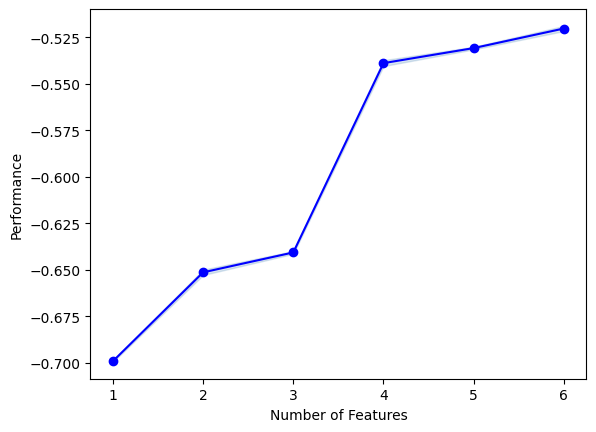

In [23]:
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')


In [18]:
list(set(sbs.k_feature_idx_).union(set(sbfs.k_feature_idx_)))



[0, 1, 2, 3, 4, 5, 6, 7]

In [10]:

# Объединение индексов выбранных признаков из SBS и SBFS для обучения
selected_features = list(set(sbs.k_feature_idx_).union(set(sbfs.k_feature_idx_)))
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]


# Обучение модели линейной регрессии на выбранных признаках
model = LinearRegression()
model.fit(X_train_selected, y_train)

LinearRegression()

In [6]:
X_train_selected[0]

array([   3.2596    ,   33.        ,    5.0176565 ,    1.00642055,
         32.71      , -117.03      ,    3.2596    ,   33.        ,
          5.0176565 ,    1.00642055,   32.71      , -117.03      ])